# 03 - Feature Engineering

This notebook creates the feature set for the NIFTY options trading strategy. We generate:
- **EMA Features**: Exponential Moving Averages (5 & 15 periods)
- **Derived Features**: IV metrics, Put-Call Ratio, ATR, volatility
- **Greeks Features**: Delta, Gamma, Theta, Vega, Rho for both calls and puts
- **Time Features**: Hour, minute, day of week, session flags
- **Lag Features**: Lagged values for key indicators

## 1. Setup and Imports

In [1]:
# IMPORTANT: Reload modules to pick up code changes
import importlib
import sys

# Remove cached modules
modules_to_reload = [mod for mod in sys.modules.keys() if mod.startswith('src')]
for mod in modules_to_reload:
    del sys.modules[mod]

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.features import (
    create_feature_set,
    add_ema_features,
    add_derived_features,
    add_greeks_features,
    add_time_features,
    add_lag_features,
    get_hmm_features,
    get_ml_features
)

print("✓ All imports successful (modules reloaded)")

✓ All imports successful (modules reloaded)


## 2. Load Merged Data

In [2]:
# Load the merged dataset from notebook 02
df = pd.read_csv('../data/nifty_merged_5min.csv', parse_dates=['timestamp'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns ({len(df.columns)}):")
print(df.columns.tolist())

Dataset shape: (19490, 27)
Date range: 2025-01-16 09:15:00 to 2026-01-16 12:55:00

Columns (27):
['timestamp', 'open', 'high', 'low', 'close', 'volume', 'futures_open', 'futures_high', 'futures_low', 'futures_close', 'futures_volume', 'futures_oi', 'contract_month', 'days_to_expiry', 'atm_strike', 'atm_call_ltp', 'atm_call_iv', 'atm_call_oi', 'atm_call_volume', 'atm_put_ltp', 'atm_put_iv', 'atm_put_oi', 'atm_put_volume', 'total_call_oi', 'total_put_oi', 'total_call_volume', 'total_put_volume']


In [3]:
# Preview the data
df.head()

,timestamp,open,high,low,close,volume,futures_open,futures_high,futures_low,futures_close,...,atm_call_oi,atm_call_volume,atm_put_ltp,atm_put_iv,atm_put_oi,atm_put_volume,total_call_oi,total_put_oi,total_call_volume,total_put_volume
0,2025-01-16 09:15:00,22000.000000,22039.687635,21972.472913,22011.370649,5909734,22053.762906,22093.547529,22026.168549,22065.161342,...,86467,2443,186.00,0.1266,93675,4774,501756,480557,32092,30536
1,2025-01-16 09:20:00,22011.370649,22028.531533,21973.322484,22008.742873,4705479,22052.330019,22069.522836,22014.211053,22049.697353,...,109358,5952,211.87,0.1392,93981,8271,450163,525399,21627,33445
2,2025-01-16 09:25:00,22008.742873,22044.638233,21930.025636,22023.570468,2016527,22055.529431,22091.501098,21976.644856,22070.388547,...,110942,3786,197.94,0.1118,115826,6379,466538,548264,24736,31089
3,2025-01-16 09:30:00,22023.570468,22059.351037,21955.816351,22057.868672,2617294,22068.666167,22104.520000,22000.773315,22103.034600,...,95880,7108,215.14,0.1267,119937,3387,476151,516543,28583,27450
4,2025-01-16 09:35:00,22057.868672,22074.789770,22040.942025,22053.101978,5063774,22118.397784,22135.365315,22101.424688,22113.618009,...,112192,6408,174.64,0.1004,97067,6575,480523,513496,20844,34971


## 3. Feature Engineering

We use the `create_feature_set()` function which applies all feature transformations:
1. EMA features (5 & 15 period)
2. Derived features (IV, PCR, ATR, volatility, basis)
3. Greeks features (Delta, Gamma, Theta, Vega, Rho)
4. Time features (hour, minute, day of week, session flags)
5. Lag features (lagged values of key indicators)

In [4]:
# Apply all feature engineering
df_features = create_feature_set(df)

print(f"Original columns: {len(df.columns)}")
print(f"After feature engineering: {len(df_features.columns)}")
print(f"New features added: {len(df_features.columns) - len(df.columns)}")

Original columns: 27
After feature engineering: 86
New features added: 59


In [5]:
# Verify new stationary features were created
stationary_features = ['log_returns', 'rsi', 'distance_from_ema5', 'distance_from_ema15', 
                       'distance_from_ema50', 'atr_pct', 'momentum_5', 'momentum_10',
                       'rsi_oversold', 'rsi_overbought']

print("Checking for new stationary features:")
for feat in stationary_features:
    if feat in df_features.columns:
        print(f"  ✓ {feat}")
    else:
        print(f"  ✗ {feat} MISSING!")

print(f"\nStationary features found: {sum(1 for f in stationary_features if f in df_features.columns)}/{len(stationary_features)}")

Checking for new stationary features:
  ✓ log_returns
  ✓ rsi
  ✓ distance_from_ema5
  ✓ distance_from_ema15
  ✓ distance_from_ema50
  ✓ atr_pct
  ✓ momentum_5
  ✓ momentum_10
  ✓ rsi_oversold
  ✓ rsi_overbought

Stationary features found: 10/10


In [6]:
# List all new features added
original_cols = set(df.columns)
new_cols = [col for col in df_features.columns if col not in original_cols]

print("New features created:")
for i, col in enumerate(new_cols, 1):
    print(f"  {i:2d}. {col}")

New features created:
   1. ema_5
   2. ema_15
   3. ema_50
   4. distance_from_ema5
   5. distance_from_ema15
   6. distance_from_ema50
   7. ema_diff
   8. ema_diff_pct
   9. avg_iv
  10. iv_spread
  11. pcr_oi
  12. pcr_volume
  13. futures_basis
  14. log_returns
  15. futures_log_returns
  16. spot_returns
  17. futures_returns
  18. rsi
  19. rsi_oversold
  20. rsi_overbought
  21. atr
  22. atr_pct
  23. volatility_20
  24. momentum_5
  25. momentum_10
  26. call_delta
  27. call_gamma
  28. call_theta
  29. call_vega
  30. call_rho
  31. put_delta
  32. put_gamma
  33. put_theta
  34. put_vega
  35. put_rho
  36. delta_neutral_ratio
  37. gamma_exposure
  38. net_delta
  39. hour
  40. minute
  41. day_of_week
  42. is_morning
  43. is_last_hour
  44. time_of_day
  45. log_returns_lag_1
  46. log_returns_lag_5
  47. log_returns_lag_10
  48. rsi_lag_1
  49. rsi_lag_5
  50. rsi_lag_10
  51. avg_iv_lag_1
  52. avg_iv_lag_5
  53. avg_iv_lag_10
  54. pcr_oi_lag_1
  55. pcr_oi_lag_5


## 4. Feature Visualization

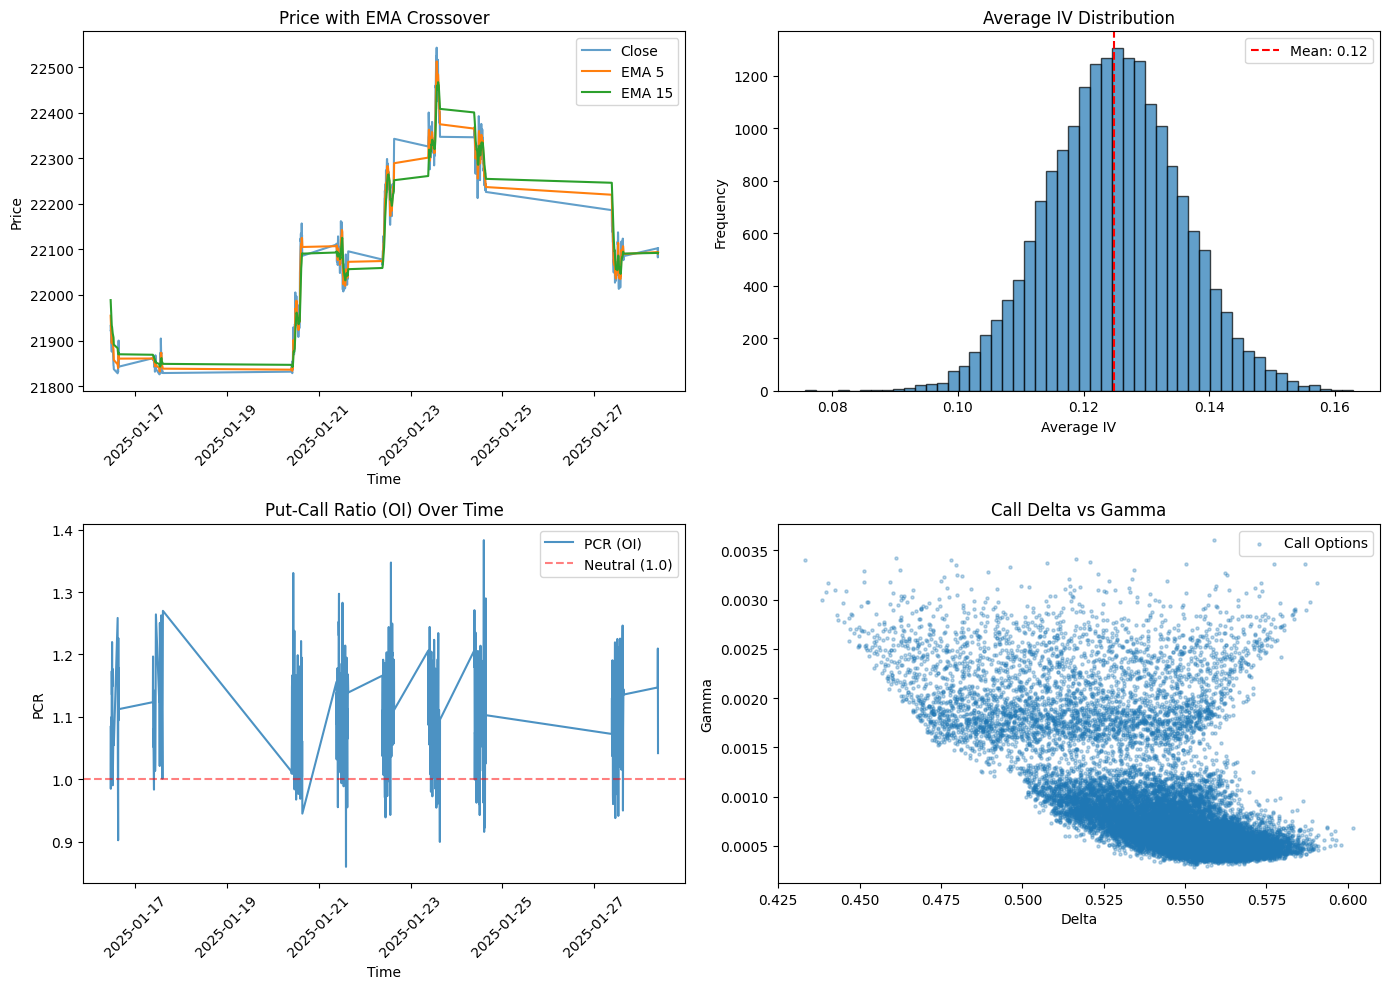

✓ Plot saved to ../plots/03_feature_engineering.png


In [7]:
# Create visualization of key features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. EMA Crossover with Price
ax1 = axes[0, 0]
sample = df_features.head(500)  # First 500 points for clarity
ax1.plot(sample['timestamp'], sample['close'], label='Close', alpha=0.7)
ax1.plot(sample['timestamp'], sample['ema_5'], label='EMA 5', linewidth=1.5)
ax1.plot(sample['timestamp'], sample['ema_15'], label='EMA 15', linewidth=1.5)
ax1.set_title('Price with EMA Crossover')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. IV Distribution
ax2 = axes[0, 1]
ax2.hist(df_features['avg_iv'].dropna(), bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(df_features['avg_iv'].mean(), color='red', linestyle='--', label=f"Mean: {df_features['avg_iv'].mean():.2f}")
ax2.set_title('Average IV Distribution')
ax2.set_xlabel('Average IV')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. PCR Over Time
ax3 = axes[1, 0]
ax3.plot(sample['timestamp'], sample['pcr_oi'], label='PCR (OI)', alpha=0.8)
ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Neutral (1.0)')
ax3.set_title('Put-Call Ratio (OI) Over Time')
ax3.set_xlabel('Time')
ax3.set_ylabel('PCR')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# 4. Greeks (Delta and Gamma)
ax4 = axes[1, 1]
ax4.scatter(df_features['call_delta'].dropna(), df_features['call_gamma'].dropna(), 
            alpha=0.3, s=5, label='Call Options')
ax4.set_title('Call Delta vs Gamma')
ax4.set_xlabel('Delta')
ax4.set_ylabel('Gamma')
ax4.legend()

plt.tight_layout()
plt.savefig('../plots/03_feature_engineering.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Plot saved to ../plots/03_feature_engineering.png")

## 5. Validate HMM Features

The regime detection model (notebook 04) requires specific features for Hidden Markov Model training.

In [8]:
# Check HMM required features
hmm_feature_cols = ['avg_iv', 'iv_spread', 'pcr_oi', 'call_delta', 'call_gamma', 'call_vega', 'futures_basis', 'spot_returns']
print("HMM Required Features:")
print(hmm_feature_cols)

# Verify all are present
missing = [f for f in hmm_feature_cols if f not in df_features.columns]
if missing:
    print(f"\n⚠ Missing features: {missing}")
else:
    print("\n✓ All HMM features present!")
    
# Show statistics for HMM features
print("\nHMM Feature Statistics:")
df_features[hmm_feature_cols].describe()

HMM Required Features:
['avg_iv', 'iv_spread', 'pcr_oi', 'call_delta', 'call_gamma', 'call_vega', 'futures_basis', 'spot_returns']

✓ All HMM features present!

HMM Feature Statistics:


,avg_iv,iv_spread,pcr_oi,call_delta,call_gamma,call_vega,futures_basis,spot_returns
count,19467.000000,19467.000000,19467.000000,19467.000000,19467.000000,19467.000000,19467.000000,19467.000000
mean,0.124877,-0.009906,1.102991,0.542581,0.000933,18.772780,0.002376,0.000026
std,0.010519,0.007096,0.077549,0.024351,0.000615,8.008426,0.001722,0.001010
min,0.075700,-0.036300,0.841285,0.433301,0.000286,4.495859,-0.001673,-0.003921
25%,0.117750,-0.014700,1.048325,0.531072,0.000518,12.692037,0.000924,-0.000650
50%,0.124900,-0.009900,1.099764,0.547894,0.000674,19.641479,0.002285,0.000027
75%,0.131900,-0.005100,1.153952,0.559328,0.001054,24.988067,0.003723,0.000707
max,0.162800,0.021200,1.441084,0.601503,0.003604,35.111247,0.007477,0.004546


In [9]:
# Check ML features (get feature columns from the dataframe)
ml_features = get_ml_features(df_features)
print(f"ML Model Features ({len(ml_features)}):")
for i, f in enumerate(ml_features, 1):
    print(f"  ✓ {f}")

ML Model Features (64):
  ✓ futures_oi
  ✓ atm_call_iv
  ✓ atm_call_oi
  ✓ atm_call_volume
  ✓ atm_put_iv
  ✓ atm_put_oi
  ✓ atm_put_volume
  ✓ total_call_oi
  ✓ total_put_oi
  ✓ total_call_volume
  ✓ total_put_volume
  ✓ distance_from_ema5
  ✓ distance_from_ema15
  ✓ distance_from_ema50
  ✓ ema_diff
  ✓ ema_diff_pct
  ✓ avg_iv
  ✓ iv_spread
  ✓ pcr_oi
  ✓ pcr_volume
  ✓ futures_basis
  ✓ log_returns
  ✓ futures_log_returns
  ✓ spot_returns
  ✓ futures_returns
  ✓ rsi
  ✓ rsi_oversold
  ✓ rsi_overbought
  ✓ atr
  ✓ atr_pct
  ✓ volatility_20
  ✓ momentum_5
  ✓ momentum_10
  ✓ call_delta
  ✓ call_gamma
  ✓ call_theta
  ✓ call_vega
  ✓ call_rho
  ✓ put_delta
  ✓ put_gamma
  ✓ put_theta
  ✓ put_vega
  ✓ put_rho
  ✓ delta_neutral_ratio
  ✓ gamma_exposure
  ✓ net_delta
  ✓ is_morning
  ✓ is_last_hour
  ✓ time_of_day
  ✓ log_returns_lag_1
  ✓ log_returns_lag_5
  ✓ log_returns_lag_10
  ✓ rsi_lag_1
  ✓ rsi_lag_5
  ✓ rsi_lag_10
  ✓ avg_iv_lag_1
  ✓ avg_iv_lag_5
  ✓ avg_iv_lag_10
  ✓ pcr_oi_lag_1

## 6. Data Quality Check

In [10]:
# Check for missing values in new features
new_feature_cols = [col for col in df_features.columns if col not in df.columns]
nan_counts = df_features[new_feature_cols].isnull().sum()
nan_pct = (nan_counts / len(df_features) * 100).round(2)

nan_summary = pd.DataFrame({
    'Feature': nan_counts.index,
    'NaN Count': nan_counts.values,
    'NaN %': nan_pct.values
}).sort_values('NaN Count', ascending=False)

print("Missing Values in New Features:")
print(nan_summary[nan_summary['NaN Count'] > 0].to_string(index=False))
print(f"\nTotal rows: {len(df_features)}")

Missing Values in New Features:
Empty DataFrame
Columns: [Feature, NaN Count, NaN %]
Index: []

Total rows: 19467


In [11]:
# Statistical summary of key features
key_features = ['ema_5', 'ema_15', 'ema_diff_pct', 'avg_iv', 'iv_spread', 
                'pcr_oi', 'pcr_volume', 'spot_returns', 'atr', 'volatility_20',
                'call_delta', 'call_gamma', 'put_delta', 'put_gamma']

print("Statistical Summary of Key Features:")
df_features[key_features].describe().round(4)

Statistical Summary of Key Features:


,ema_5,ema_15,ema_diff_pct,avg_iv,iv_spread,pcr_oi,pcr_volume,spot_returns,atr,volatility_20,call_delta,call_gamma,put_delta,put_gamma
count,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000,19467.0000
mean,27465.0948,27461.4384,0.0126,0.1249,-0.0099,1.1030,1.1601,0.0000,109.9410,0.1373,0.5426,0.0009,-0.4600,0.0009
std,3645.0038,3643.0727,0.1105,0.0105,0.0071,0.0775,0.3866,0.0010,20.0117,0.0223,0.0244,0.0006,0.0226,0.0006
min,21831.9444,21842.3359,-0.3680,0.0757,-0.0363,0.8413,0.2120,-0.0039,53.0055,0.0673,0.4333,0.0003,-0.5555,0.0003
25%,24907.2807,24908.1240,-0.0624,0.1178,-0.0147,1.0483,0.8930,-0.0007,95.8986,0.1221,0.5311,0.0005,-0.4707,0.0005
50%,26137.4837,26137.3819,0.0131,0.1249,-0.0099,1.0998,1.1033,0.0000,106.7244,0.1365,0.5479,0.0007,-0.4550,0.0006
75%,29955.9859,29950.4148,0.0868,0.1319,-0.0051,1.1540,1.3570,0.0007,122.1564,0.1525,0.5593,0.0011,-0.4444,0.0010
max,36281.6502,36249.4288,0.3943,0.1628,0.0212,1.4411,4.4025,0.0045,200.2247,0.2280,0.6015,0.0036,-0.4079,0.0034


## 7. Save Feature Dataset

In [12]:
# Save the feature dataset
output_path = '../data/nifty_features_5min.csv'
df_features.to_csv(output_path, index=False)

print(f"✓ Feature dataset saved to {output_path}")
print(f"  Shape: {df_features.shape}")
print(f"  Columns: {len(df_features.columns)}")

✓ Feature dataset saved to ../data/nifty_features_5min.csv
  Shape: (19467, 86)
  Columns: 86


## Summary

Feature engineering complete! The following feature groups were created:

| Group | Features |
|-------|----------|
| **EMA** | ema_5, ema_15, ema_diff, ema_diff_pct |
| **IV & PCR** | avg_iv, iv_spread, pcr_oi, pcr_volume |
| **Returns & Volatility** | spot_returns, futures_returns, futures_basis, atr, volatility_20 |
| **Call Greeks** | call_delta, call_gamma, call_theta, call_vega, call_rho |
| **Put Greeks** | put_delta, put_gamma, put_theta, put_vega, put_rho |
| **Derived Greeks** | delta_neutral_ratio, gamma_exposure, net_delta |
| **Time** | hour, minute, day_of_week, is_morning, is_last_hour, time_of_day |
| **Lag** | close_lag_1/5/10, avg_iv_lag_1/5/10, pcr_oi_lag_1/5/10, spot_returns_lag_1/5/10 |

**Next:** Proceed to notebook `04_regime_detection.ipynb` for HMM regime detection.